# Quantum Phase Estimation (QPE) for Solving Molecular Energies


Quantum Phase Estimation (QPE) is a key algorithm in quantum computing for estimating the phase (or eigenvalue) of an eigenvector of a unitary operation. For a given Hamiltonian $H$ and an eigenvalue ${|\psi\rangle}$, the output of the algorithm is $\epsilon$ where

$U{|\psi\rangle} = e^{2\pi i\epsilon}{|\psi\rangle} , U = e^{2\pi iH}$.


Therefore, by measuring the accumulated phase, the QPE algorithm calculates the energies relating to the chosen initial state.
When using QPE for chemistry problems, it is common to search for the lowest energy of a given molecule. As the molecule can be written in the form of a Hamiltonian (a Hermitian matrix representing the energetic forces of the structure), to obtain the minimal energy value using QPE, you only need to insert the ground eigenvector. However, obtaining the ground state is not a trivial problem. To overcome this, it is sufficient to use a state with big overlap with the ground state.

Define a state ${|v\rangle}$ as the algorithm's initial state. Define {$\psi_i$} as the set of (unknown) eigenvalues of $H$. Generally, any vector can be rewritten as a superposition of any basis set, thus

${|v\rangle} = \sum_i a_i{|\psi_i\rangle}$

and

$U{|v\rangle} = \sum_i a_i e^{2\pi i\epsilon_i}{|\psi_i\rangle}$

where ${\epsilon_i}$ are the eigenvalues of $H$, i.e., the span of energies relating to the molecule. Using execution with enough shots, you obtain this set of $\epsilon_i$, i.e., a subset of the Hamiltonian's eigenvalues. As you are specifically interested in $\epsilon_0$, the ground state of $H$, it is important to have a large overlap between ${\psi_0}$ and ${|v\rangle}$ so the probability to measure ${\epsilon_0}$ is high, i.e.,

$P(\epsilon_0) = |\langle v|\psi_0\rangle|^2 > \zeta $.

How large is $\zeta$? After execution, you obtain a set of ${E_i}$. If you have 1000 execution shots and $P(\epsilon_0)>1\%$, you should sample $\epsilon_0$ roughly 10 times.

A common choice for ${|v\rangle}$ (the initial state) is the Hartree-Fock (HF) state, which typically has a large overlap with the ground state. However, other guesses for the initial state are possibly good or an even better fit, and choosing the right initial state is an art and an active field of research.

To read more about QPE, refer to [[1](#NC)].


**What are the benefits of using the QPE algorithm to find a molecule's ground state?**

The two most prominent methods to solve ground energy for molecules are quantum variational algorithm (VQE) and QPE. They promise better scalability compared to their classical counterparts as the molecules become more complex, with a larger number of electrons, referring to a physical problem with more degrees of freedom.

The number of parameters in VQE is closely related to the number of electrons. This may create an inherent difficulty achieving high-precision calculations through sampling statistical estimators, and may not even converge for very large systems. On the other hand, the number of parameters in QPE is a flexible value that is directly related to the resolution of the problem, but is not bounded with the number of electrons.

Furthermore, it is known that advanced quantum algorithms based on QPE can perform electronic structure calculations in sub-exponential time with accuracy that rivals exact diagonalization methods. This guarantee of simultaneously achieving high accuracy, efficiency, and generality is a feat that is believed to be impossible for classical algorithms. For these reasons, VQE is applicable in the near term (NISQ) era, while QPE is suited for fault-tolerant design.

**This tutorial follows the QPE algorithm steps as follows:**

1. Define a molecule and convert it into a Hamiltonian.

2. Prepare the Hamiltonian for QPE, including normalization and trimming of negligible terms.

3. Construct a quantum model, initializing the state for the HF state and leveraging the `qpe_flexible` function.

4. Execute the circuit to find the related phases and analyze the results to find the ground state.

In [1]:
!pip install -qq "classiq[chemistry]"

In [2]:
## Imports

import matplotlib.pyplot as plt
import numpy as np

from classiq import *
from classiq.applications.chemistry.op_utils import qubit_op_to_pauli_terms

# for chemistry
from classiq.applications.chemistry.problems import FermionHamiltonianProblem
from classiq.applications.chemistry.z2_symmetries import Z2SymTaperMapper

## Defining a Molecule with Classiq

This tutorial works with the LiH molecule:

In [3]:
molecule_H2_geometry = [("H", (0.0, 0.0, 0)), ("H", (0.0, 0.0, 0.735))]
molecule_O2_geometry = [("O", (0.0, 0.0, 0)), ("O", (0.0, 0.0, 1.16))]
molecule_LiH_geometry = [("H", (0.0, 0.0, 0.0)), ("Li", (0.0, 0.0, 1.596))]
molecule_H2O_geometry = [
    ("O", (0.0, 0.0, 0.0)),
    ("H", (0, 0.586, 0.757)),
    ("H", (0, 0.586, -0.757)),
]
molecule_BeH2_geometry = [
    ("Be", (0.0, 0.0, 0.0)),
    ("H", (0, 0, 1.334)),
    ("H", (0, 0, -1.334)),
]

molecule_geometry = molecule_LiH_geometry

In [4]:
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf

geometry = molecule_H2_geometry

basis = "sto-3g"  # Basis set
multiplicity = 1  # Singlet state S=0
charge = 0  # Neutral molecule
molecule = MolecularData(molecule_geometry, basis, multiplicity, charge)

molecule = run_pyscf(
    molecule,
    run_mp2=True,
    run_cisd=True,
    run_ccsd=True,
    run_fci=True,  # relevant for small, classically solvable problems
)

In [5]:
# define your molecule problem and mapper

problem = FermionHamiltonianProblem.from_molecule(
    molecule=molecule, first_active_index=1
)
mapper = Z2SymTaperMapper.from_problem(problem)
num_qubits = mapper.get_num_qubits(problem)

constant_energy = problem.fermion_hamiltonian.constant
mol_hamiltonian = mapper.map(problem.fermion_hamiltonian - constant_energy)

print(
    f"The Hamiltonian is defined on {num_qubits} qubits, and contains {len(mol_hamiltonian.terms)} Pauli strings"
)

The Hamiltonian is defined on 6 qubits, and contains 231 Pauli strings


Finally, we calculate the ground state energy as a reference solution to the quantum solver

In [6]:
classical_sol = molecule.fci_energy
print(f"Expected energy: {classical_sol} Ha")

Expected energy: -7.882386993638953 Ha


## Preparing the Molecule for QPE

### Trimming the Hamiltonian

As you can see, the Hamiltonian may contain a large number of terms. In many cases you can compress the Hamiltonian by trimming small terms:

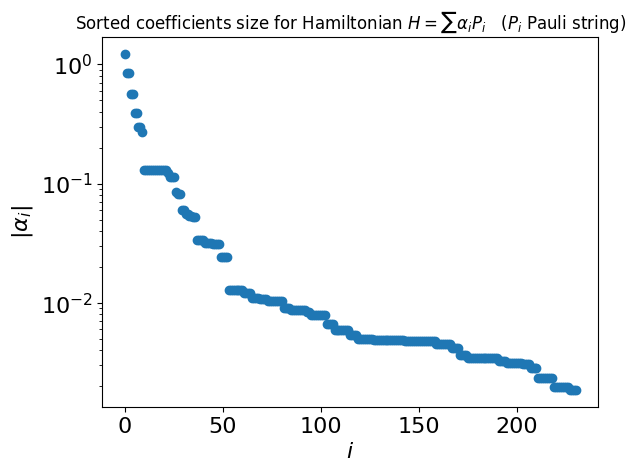

In [7]:
coeffs = list(mol_hamiltonian.terms.values())
plt.semilogy(np.sort(np.abs(coeffs))[::-1], "o")
plt.ylabel(r"$|\alpha_i|$", fontsize=16)
plt.xlabel(r"$i$", fontsize=16)
plt.tick_params(axis="both", labelsize=16)
plt.title(
    r"Sorted coefficients size for Hamiltonian $H = \sum \alpha_i P_i$   ($P_i$ Pauli string)"
);

Define a threshold and trim the Hamiltonian accordingly:

In [8]:
THRESHOLD = 0.03

mol_hamiltonian.compress(THRESHOLD)
print(f"Length of trimmed Hamiltonian: {len(mol_hamiltonian.terms)}")

Length of trimmed Hamiltonian: 49


### Normalizing the Hamiltonian for QPE

Since you are working with QPE, the ground state energy is inferred as a phase. Therefore, normalize the Hamiltonian so that its eigenvalues are in $\left[-\frac{1}{2},\frac{1}{2}\right)$. This is done by finding a bound on the maximal absolute value of eigenvalues $\tilde{\lambda}_{\max}$ and normalizing the Hamiltonian by $2\tilde{\lambda}_{\max}$. A simple bound is given by the sum of Pauli coefficients of the Hamiltonian:

In [9]:
def normalize_hamiltonian(hamiltonian):
    approx_lambda_max = sum(np.abs(value) for value in hamiltonian.terms.values())
    normalization = 2 * approx_lambda_max

    normalized_mol_hamiltonian = hamiltonian * (1 / normalization)
    return normalization, normalized_mol_hamiltonian


normalization, normalized_mol_hamiltonian = normalize_hamiltonian(mol_hamiltonian)
print(f"The normalization value of the Hamiltonian is {normalization}")

The normalization value of the Hamiltonian is 17.61546220154498


## Designing the Quantum Model

### Defining a Powered Hamiltonian Simulation

Create a quantum model of the QPE algorithm using the Classiq platform, in particular, using the open library  [qpe_flexible](https://github.com/Classiq/classiq-library/blob/main/functions/qmod_library_reference/classiq_open_library/qpe/qpe.ipynb) function (and see this [notebook](https://github.com/Classiq/classiq-library/blob/main/tutorials/advanced_tutorials/high_level_modeling_flexible_qpe/high_level_modeling_flexible_qpe.ipynb) as well).

To approximate the Hamiltonian simulation $e^{2\pi i H}$, use the Classiq built-in implementation for [Suzuki-Trotter formulas](https://github.com/Classiq/classiq-library/blob/main/functions/qmod_library_reference/qmod_core_library/hamiltonian_evolution/suzuki_trotter/suzuki_trotter.ipynb). For a given Suzuki-Trotter order $o$, you can specify a repetition parameter $r$ that controls the level of approximation. The literature provides lower bounds for $r$ as a function of the operator error $\epsilon$ (defined by the diamond norm [[3](#Dimond)]). For example, Eq. (14) in Ref. [[2](#Bounds)] states that the Suzuki-Trotter formula of order 2 approximates $e^{i \sum \alpha_m P_m t}$ up to an error $\epsilon$, given $r$ repetitions that satisfies
$$
r \leq \left(\frac{2^5\gamma_2}{3\epsilon}\right)^{1/2}  t^{3/2},
\tag{1}
$$
where $\gamma_2 \equiv \sum_{l,m,n} |\alpha_m\alpha_n\alpha_l| \left |\left[P_l,\left[P_m, P_n\right]\right]\right|_\infty$. **In particular, note that the number of repetitions grows as $t^{3/2}$**.


In QPE, apply a powered Hamiltonian simulation:
$$
\left(e^{2\pi i H}\right)^ p = e^{2p \pi i H},
\tag{2}
$$
and approximate each power with Suzuki-Trotter for appropriate order and repetition parameters, keeping the same error per QPE iteration. You can thus use the bound above to define a powered Suzuki-Trotter `qfunc` for the specific molecule.

In particular, in QPE the powered unitary $U^k$ is applied for getting $U^k|\psi\rangle = e^{2\pi i k\theta}|\psi\rangle $ for eigenstate $|\psi\rangle $and eigenphase $\theta$ of $U$. Thus, if we approximate $\tilde{U}\approx U$ such that it has an eignphase $|\tilde{\theta}-\theta| < \epsilon$, keeping the same relevant error for $U^k$ means that $\tilde{U}^{(k)}\approx U^k$ has an eignephase $|k\tilde{\theta}-k\theta| < k\epsilon$. Finally, if we replace $t$ with $k$ in Eq. (1) (since the power of $e^{iH}$ corresponds to the evolution time $t$, according to Eq. (2)), we have 
$$
r(k) \leq \left(\frac{2^5\gamma_2}{3\epsilon(k)}\right)^{1/2}  k^{3/2}= \left(\frac{2^5\gamma_2}{3\epsilon k}\right)^{1/2}  k^{3/2}
= \left(\frac{2^5\gamma_2}{3\epsilon}\right)^{1/2}  k^{1/2}.
\tag{3}
$$
This is the relation between the repetitions $r$ and the power of a second-order Suzuki-Trotter formula (in a sense of an upper bound).

First, define a classical auxiliary function that help evaluate the right-hand-side side of Eq. (1):

In [10]:
import itertools

from openfermion import QubitOperator
from openfermion.utils import commutator


def calculate_gamma_2(hamiltonian):
    """
    Compute the $\gamma_2$ value appearing in the bound for Suzuki Trotter of order 2
    """
    gamma_2 = 0
    for triplet in itertools.combinations(range(len(hamiltonian.terms)), 3):
        terms = [list(hamiltonian.terms.keys())[index] for index in triplet]
        values = [list(hamiltonian.terms.values())[index] for index in triplet]
        factor = np.abs(values[0] * values[1] * values[2])
        inner_commutator = commutator(
            QubitOperator(terms[1], 1), QubitOperator(terms[0], 1)
        ).induced_norm()
        if inner_commutator != 0:
            outer_commutator = (
                2
                * commutator(
                    QubitOperator(terms[2], 1),
                    QubitOperator(terms[0], 1) * QubitOperator(terms[1], 1),
                ).induced_norm()
            )
            gamma_2 += factor * outer_commutator

    return gamma_2

In QPE, the power of the Hamiltonian simulation grows exponentially with the phase variable size. Examine the number of repetitions needed per QPE iteration, according to the bound above for QPE of size 7:

In [11]:
QPE_SIZE = 7
qpe_powers = 2 ** np.arange(QPE_SIZE)
print(
    f"""The power of the Hamiltonian simulation along a QPE routine of size {QPE_SIZE}: 
{qpe_powers}"""
)

The power of the Hamiltonian simulation along a QPE routine of size 7: 
[ 1  2  4  8 16 32 64]


These powers enter as an evolution coefficient for the Hamiltonian simulation (see Eq. (2) above). Using the theoretical bound, we find this:

In [12]:
EPS = 0.1
gamma_2_LiH = calculate_gamma_2(normalized_mol_hamiltonian)
theoretical_r0 = np.sqrt(2**5 * gamma_2_LiH / (3 * EPS)) * (2 * np.pi) ** (1 / 2)

print(
    f"""The theoretical bounds for the repetitions for QPE size {QPE_SIZE}, keeping an error {EPS} per QPE iteration are:
{np.ceil(theoretical_r0*qpe_powers**(1/2))}"""
)

The theoretical bounds for the repetitions for QPE size 7, keeping an error 0.1 per QPE iteration are:
[1. 1. 2. 2. 3. 4. 6.]


Note that applying a naive QPE, i.e., assuming a single unitary approximated with Suzuki-Trotter, $e^{iHt} \approx {\rm ST}(H, o, r ,t)$, and simply taking its powers, gives $\left(e^{iHt}\right)^p \approx \left({\rm ST}(H, o, r ,t)\right)^{p} = {\rm ST}(H, o, pr ,pt)$.

In [13]:
print(
    f"""The repetitions for QPE size {QPE_SIZE}, taking a naive QPE, per QPE iteration:
{np.ceil(theoretical_r0*qpe_powers)}"""
)

The repetitions for QPE size 7, taking a naive QPE, per QPE iteration:
[ 1.  2.  3.  6. 11. 21. 42.]


In practice, the bounds given in the literature are quite loose. This tutorial therefore takes a more experimental approach, assuming that the scaling of the bound with the evolution time $t$ is similar to Eq. (1), but taking a smaller prefactor.

In [14]:
experimental_r0 = 0.5
print(
    f"""The experimental repetitions for QPE size {QPE_SIZE}, per QPE iteration are:
{np.ceil(experimental_r0*qpe_powers**(1/2))}"""
)

The experimental repetitions for QPE size 7, per QPE iteration are:
[1. 1. 1. 2. 2. 3. 4.]


Use this approach to define the powered Suzuki-Trotter function for the specific Hamiltonian at hand:

In [15]:
from classiq.qmod.symbolic import ceiling as ceiling_qmod, pi


@qfunc
def powered_st2_for_LiH(p: CInt, state: QArray[QBit]):
    suzuki_trotter(
        pauli_operator=qubit_op_to_pauli_terms(normalized_mol_hamiltonian),
        evolution_coefficient=-2 * np.pi * p,
        order=2,
        repetitions=ceiling_qmod(experimental_r0 * p ** (1 / 2)),
        qbv=state,
    )

### Defining and Synthesizing the Phase Estimation Model

In [16]:
from classiq.applications.chemistry.hartree_fock import get_hf_state

hf_state = get_hf_state(problem, mapper)


@qfunc
def main(
    state: Output[QArray[QBit, num_qubits]],
    phase: Output[QNum[QPE_SIZE, SIGNED, QPE_SIZE]],
) -> None:

    prepare_basis_state(hf_state, state)
    allocate(phase)
    qpe_flexible(lambda p: powered_st2_for_LiH(p, state), phase)


qmod = create_model(
    main,
    preferences=Preferences(timeout_seconds=600),
)
write_qmod(qmod, "qpe_for_molecules", symbolic_only=False)

qprog = synthesize(qmod)

## Measurement and Analysis

Execute on the default simulator:

In [17]:
res = execute(qprog).result_value()

Draw a histogram for the energies by taking the output of the `phase` variable and multiplying back the normalization factor:


Energy with maximal probability: -7.904148198365434 Ha
Precision: 0.13762079844957015 Ha
Classical solution:, -7.882386993638953 Ha


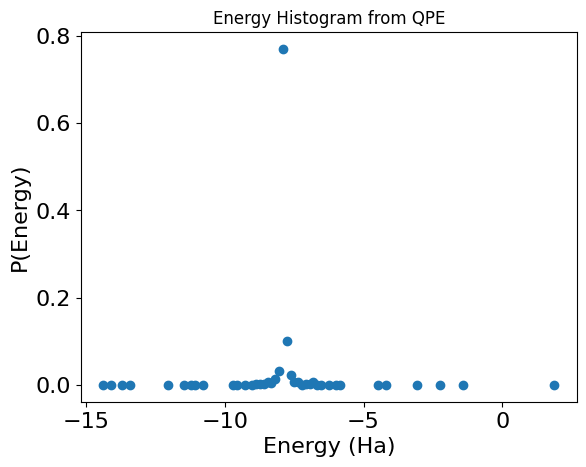

In [18]:
phase_counts = res.parsed_counts_of_outputs("phase")
num_shots = res.num_shots

energy_results = {
    sample.state["phase"] * normalization + constant_energy: sample.shots / num_shots
    for sample in phase_counts
}

plt.plot(energy_results.keys(), energy_results.values(), "o")

max_prob_energy = max(energy_results, key=energy_results.get)

print(f"\nEnergy with maximal probability: {max_prob_energy} Ha")
print(f"Precision: {(2**(-QPE_SIZE))* normalization} Ha")
print(f"Classical solution:, {classical_sol} Ha")
plt.xlabel("Energy (Ha)", fontsize=16)
plt.ylabel("P(Energy)", fontsize=16)
plt.tick_params(axis="both", labelsize=16)
plt.title("Energy Histogram from QPE");

You are looking for a signal from the smallest eigenvalue under the assumption that the initial state has some overlap with the ground state. Now, estimate the energy as the first peak of the histogram, such that the corresponding probability is larger than `ASSUMED_OVERLAP`*0.4 (0.4 is the case for ASSUMED_OVERLAP=1).

*Note that this is a very rough and simplistic analysis of the QPE algorithm result. You can utilize more complex spectral analysis tools such as Gaussian mixtures. Additional assumptions, such as the difference between adjacent eigenvalues or the number of overlapping eigenstates, can facilitate the analysis further.*

In [19]:
from scipy.signal import find_peaks

ASSUMED_OVERLAP = 0.05


def estimate_energy(data_dict, assumed_overlap):
    max_prob = assumed_overlap * 0.4
    data = tuple(data_dict.items())
    data_sorted = sorted(
        data, key=lambda x: x[0]
    )  # sort the data according to the energy value
    probs_sorted = [data[1] for data in data_sorted]
    maxima = find_peaks(probs_sorted, height=max_prob)[0]
    print(f"Number of maxima: {maxima.size}")
    if maxima.size == 0 and np.all(np.array(probs_sorted) <= max_prob):
        print(
            """No probabilities above threshold were found, try to increase the assumed_overlap. 
Returning energy with max probability"""
        )
        return max(data_dict, key=data_dict.get)
    elif maxima.size == 0:  # strictly increasing or decreasing function
        return max(data_dict, key=data_dict.get)
    else:
        print(
            f"maxima over the threshold at {[data_sorted[maxima[k]][0] for k in range(maxima.size)]} Ha"
        )
        return data_sorted[maxima[0]][0]


measured_energy = estimate_energy(energy_results, ASSUMED_OVERLAP)
print(f"\nLowest eigenvalue: {measured_energy} Ha")
print(f"Precision: {(2**(-QPE_SIZE))* normalization} Ha")
print(f"Classical solution:, {classical_sol} Ha")

Number of maxima: 1
maxima over the threshold at [-7.904148198365434] Ha

Lowest eigenvalue: -7.904148198365434 Ha
Precision: 0.13762079844957015 Ha
Classical solution:, -7.882386993638953 Ha


## References

<a name='NC'>[1]</a> [Michael A. Nielsen and Isaac L. Chuang. 2011. Quantum Computation and Quantum Information: 10th Anniversary Edition, Cambridge University Press, New York, NY, USA.
](https://archive.org/details/QuantumComputationAndQuantumInformation10thAnniversaryEdition)

<a name='Bounds'>[2]</a> [M. Hagan and N. Wiebe. Composite Quantum Simulations, Quantum 7, 1881 (2023).
](https://quantum-journal.org/papers/q-2023-11-14-1181/)

<a name='Diamond'>[3]</a> [Diamond Norm (Wikipedia).
](https://en.wikipedia.org/wiki/Diamond_norm)


